In [1]:
%matplotlib inline
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as pltcol

#plt.style.use("project_style.mplstyle")

from models import RNNGC
from plotting_functions import multiimshow
from dataset import DatasetMaker
from tqdm import tqdm
import spatial_maps as sm

In [191]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")
grid_score = np.load(f"./statistics/RNN_Grid Score.npy")
orientations = np.load(f"./statistics/RNN_Orientation.npy")
phases = np.load(f"./statistics/RNN_Phases.npy")
sort_scores = np.argsort(grid_score)


# create data
res = 64
timesteps = 10
dataset = DatasetMaker()
rt, vt = dataset.generate_data(nsteps:=40000, timesteps)

inputs = (rt[:,0], vt)
# create "labels": run model without pruning
label_g = model(inputs).detach().numpy() # double check that states are alright
ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().numpy(), rt[...,1].ravel().numpy(), label_g.reshape(-1, label_g.shape[-1]).T, bins = res)[0]

mesh = np.meshgrid(np.linspace(-dataset.box_size/2, dataset.box_size/2, res), np.linspace(-dataset.box_size/2, dataset.box_size/2, res))
mesh = np.stack(mesh, axis = -1)

threshold = 0.1
subselectmaps = ratemaps[grid_score < threshold]

In [192]:
activities = model((rt[:,0], torch.zeros(rt.shape[0], 50, 2))).detach().numpy()

In [193]:
rt.shape, activities.shape

(torch.Size([40000, 10, 2]), (40000, 51, 256))

Text(0, 0.5, 'Difference in activity')

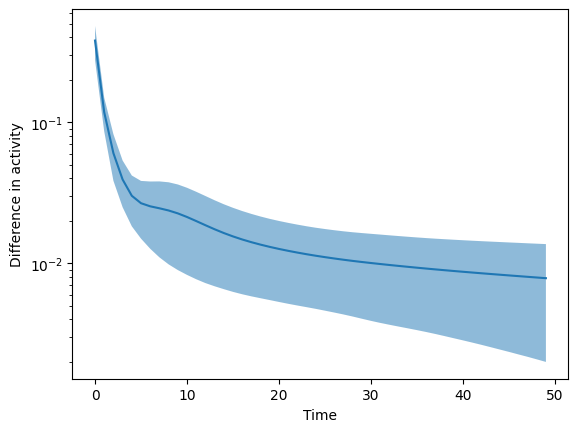

In [187]:
norm = np.linalg.norm(np.diff(activities, axis=1), axis=-1)

plt.semilogy(norm.mean(axis=0))
# fill between
plt.fill_between(np.arange(50), norm.mean(axis=0) - norm.std(axis=0), norm.mean(axis=0) + norm.std(axis=0), alpha = 0.5)
plt.xlabel("Time")
plt.ylabel("Difference in activity")

In [188]:
stable_activities = activities[:,20]

In [189]:
stable_activities.shape

(40000, 256)

In [132]:
def loss_fn(ratemap, mesh):
    ratemap = ratemap/np.max(ratemap)
    def loss_fn(x):
        phase = x[0]
        orientation = x[1]
        scale = x[2]
        bmap = band_cell(mesh.reshape(-1,2), phase=phase, orientation=orientation, scale=scale).reshape(res, res)
        return -np.sum(ratemap * bmap)
        #return np.mean((ratemap - bmap)**2)
    return loss_fn

In [133]:
from methods import band_cell

optimas = []
optimized_maps = []
for i in tqdm(range(len(subselectmaps))):
    #optima = minimize(loss_fn(subselectmaps[i], mesh), [0, np.pi/3, 2], tol=1e-6)#, method="CG")
    optima = scipy.optimize.differential_evolution(loss_fn(subselectmaps[i], mesh), bounds=[(-np.pi, np.pi), (0, 2*np.pi), (0.1, 3)], tol=1e-6, popsize=20)
    optimas.append(optima.x)
    optimized_maps.append(band_cell(mesh.reshape(-1,2), phase=optima.x[0], orientation=optima.x[1], scale=optima.x[2]).reshape(res, res))
optimas = np.array(optimas)
optimized_maps = np.array(optimized_maps)

100%|██████████| 23/23 [00:05<00:00,  4.07it/s]


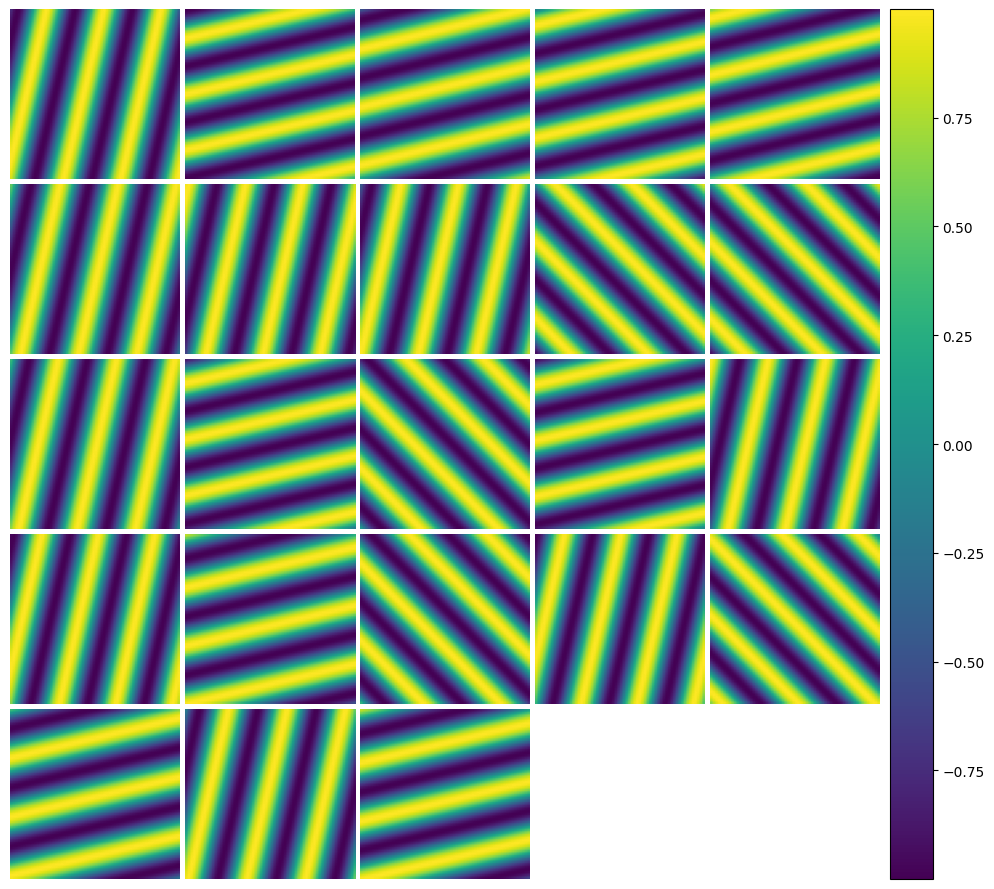

In [134]:
multiimshow(optimized_maps, cmap="viridis", figsize=(10, 10));

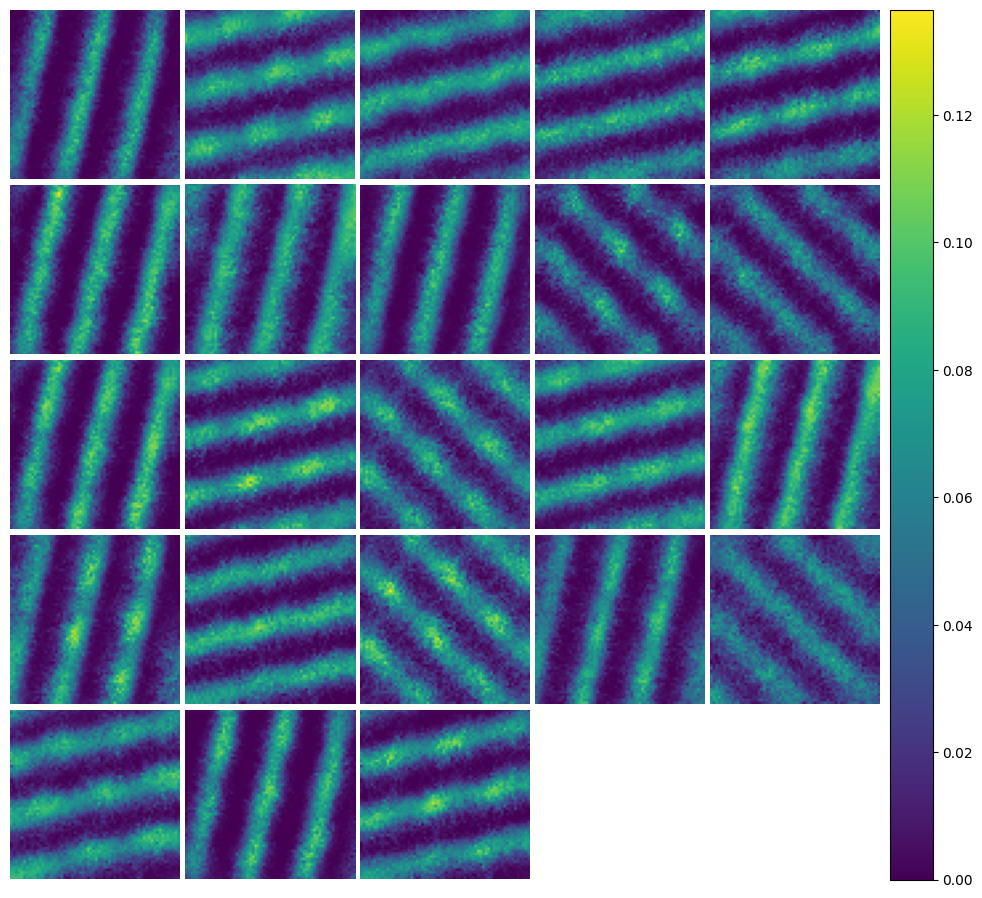

In [135]:
multiimshow(subselectmaps, cmap="viridis", figsize=(10, 10));

In [136]:
sort_phases = np.argsort(optimas[:,0])
sort_orientations = np.argsort(optimas[:,1]%np.pi/3)
mean_scale = np.mean(optimas[:,2])
sort_idxs = np.arange(len(subselectmaps))

# cluster orientations on k-means with 3 clusters
means, cluster_id = scipy.cluster.vq.kmeans2(optimas[:,1][:,None]%np.pi/3, 3)

phases0 = optimas[cluster_id == 0, 0]# % (2*np.pi/mean_scale)
phases1 = optimas[cluster_id == 1, 0]# % (2*np.pi/mean_scale)
phases2 = optimas[cluster_id == 2, 0]# % (2*np.pi/mean_scale)

sort_phases0 = np.argsort(phases0)
sort_phases1 = np.argsort(phases1)
sort_phases2 = np.argsort(phases2)

sort_idxs = np.concatenate([sort_idxs[cluster_id == 0][sort_phases0], sort_idxs[cluster_id == 1][sort_phases1], sort_idxs[cluster_id == 2][sort_phases2]])

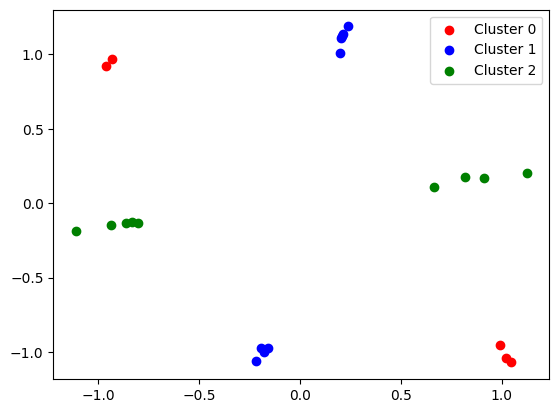

In [137]:
idxs_cluster0 = np.where(cluster_id == 0)[0]
idxs_cluster1 = np.where(cluster_id == 1)[0]
idxs_cluster2 = np.where(cluster_id == 2)[0]

cluster0_velovity_weighs = model.vg.weight.detach().numpy()[grid_score < threshold][idxs_cluster0]
cluster1_velovity_weighs = model.vg.weight.detach().numpy()[grid_score < threshold][idxs_cluster1]
cluster2_velovity_weighs = model.vg.weight.detach().numpy()[grid_score < threshold][idxs_cluster2]

plt.scatter(*cluster0_velovity_weighs.T, color="red", label="Cluster 0")
plt.scatter(*cluster1_velovity_weighs.T, color="blue", label="Cluster 1")
plt.scatter(*cluster2_velovity_weighs.T, color="green", label="Cluster 2")
plt.legend()

Text(0, 0.5, 'Firing Rate')

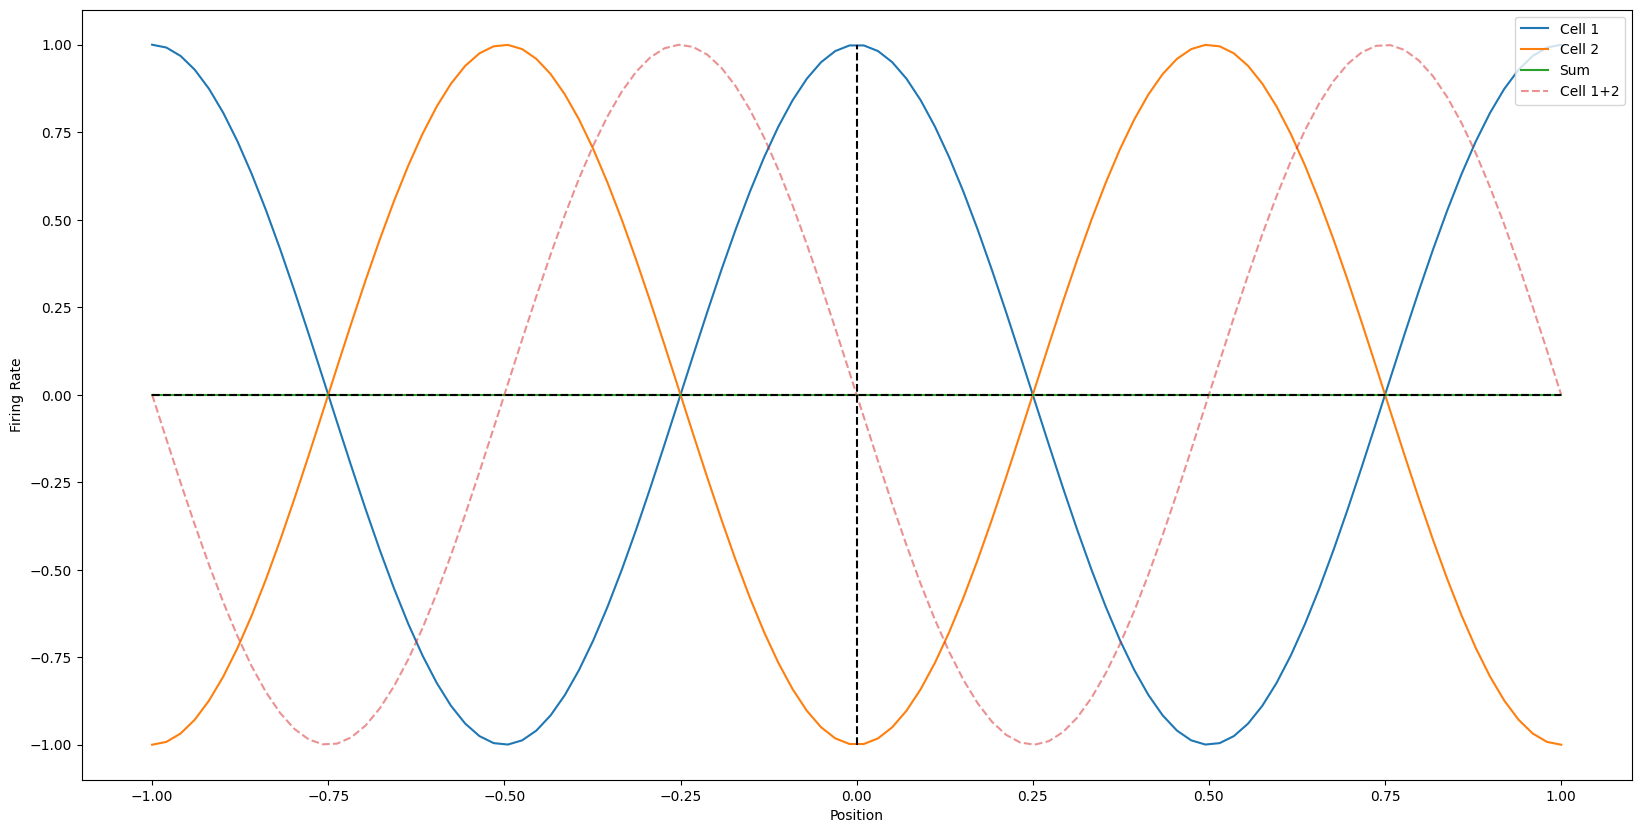

In [138]:

#
# PHASOR ADDITION STUFF
#

x = np.linspace(-1, 1, 100)
phase1 = 0
phase2 = np.pi/1.00
y1 = np.cos(2*np.pi * x + phase1)
y2 = np.cos(2*np.pi * x + phase2)
y3 = y1 + y2
#y3 = y3/np.max(y3)
y4 = np.cos(2*np.pi * x + (phase1 + phase2)/2)
plt.figure(figsize=(20, 10))
plt.plot(x, y1, label="Cell 1")
plt.plot(x, y2, label="Cell 2")
plt.plot(x, y3, label="Sum")
plt.plot(x, y4, label="Cell 1+2", linestyle="--", alpha=0.5)
plt.hlines(0, -1, 1, color="black", linestyle="--")
plt.vlines(0, -1, 1, color="black", linestyle="--")
plt.legend()
plt.xlabel("Position")
plt.ylabel("Firing Rate")

In [139]:

gg = model.gg.weight.detach().numpy()[grid_score < threshold]
gg = gg.T[grid_score < threshold].T

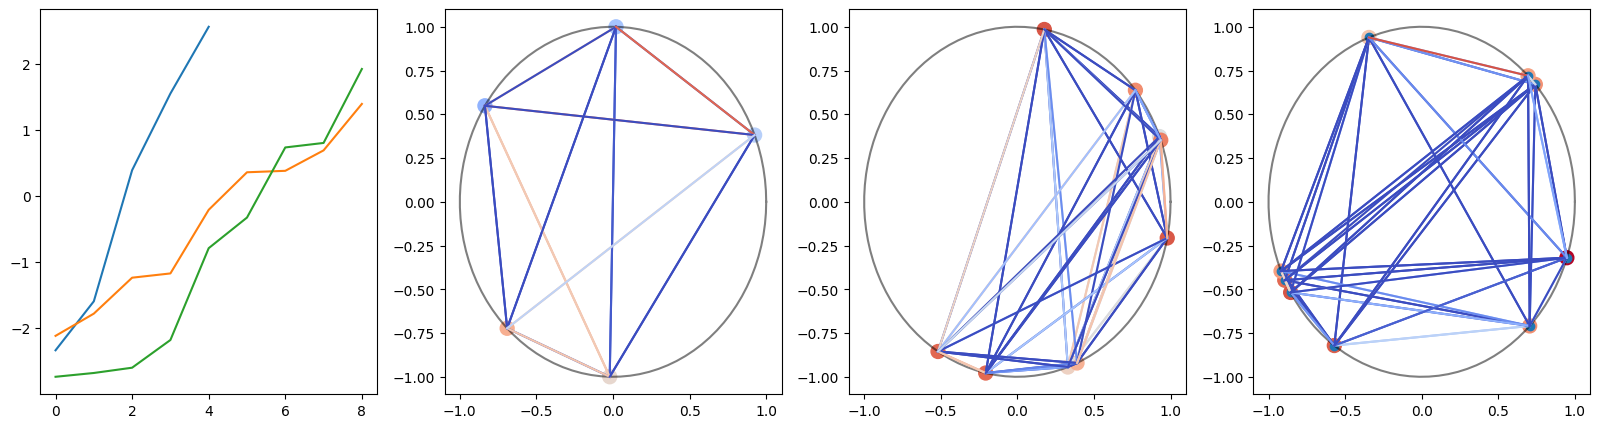

In [140]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
from matplotlib import cm

axs[0].plot(phases0[sort_phases0])
axs[0].plot(phases1[sort_phases1])
axs[0].plot(phases2[sort_phases2])

ring_coords0 = np.array([np.cos(phases0), np.sin(phases0)]).T
ring_coords1 = np.array([np.cos(phases1), np.sin(phases1)]).T
ring_coords2 = np.array([np.cos(phases2), np.sin(phases2)]).T
unit_ring = np.array([np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100))]).T

w0 = gg[cluster_id == 0].T[cluster_id == 0].T
w1 = gg[cluster_id == 1].T[cluster_id == 1].T
w2 = gg[cluster_id == 2].T[cluster_id == 2].T

axs[1].scatter(*ring_coords0.T, c=cm.coolwarm(np.diag(w0)), s=100)
axs[1].plot(*unit_ring.T, color="black", alpha=0.5)
for i in range(len(ring_coords0)):
    for j in range(len(ring_coords0)):
        axs[1].plot([ring_coords0[i,0], ring_coords0[j,0]], [ring_coords0[i,1], ring_coords0[j,1]], c=cm.coolwarm(w0[i,j]))#, color=w0[i,j])#, cmap="coolwarm")


axs[2].scatter(*ring_coords1.T, c=cm.coolwarm(np.diag(w1)), s=100)
axs[2].plot(*unit_ring.T, color="black", alpha=0.5)
for i in range(len(ring_coords1)):
    for j in range(len(ring_coords1)):
        axs[2].plot([ring_coords1[i,0], ring_coords1[j,0]], [ring_coords1[i,1], ring_coords1[j,1]], c=cm.coolwarm(w1[i,j]))#, color=w0[i,j])#, cmap="coolwarm")

axs[3].scatter(*ring_coords2.T, c=cm.coolwarm(np.diag(w2)), s=100)
axs[3].scatter(*ring_coords2.T)
axs[3].plot(*unit_ring.T, color="black", alpha=0.5)
for i in range(len(ring_coords2)):
    for j in range(len(ring_coords2)):
        axs[3].plot([ring_coords2[i,0], ring_coords2[j,0]], [ring_coords2[i,1], ring_coords2[j,1]], c=cm.coolwarm(w2[i,j]))#, color=w0[i,j])#, cmap="coolwarm")


In [141]:
optimas[cluster_id == 0, 0][sort_phases0]

array([-2.3336853 , -1.59222932,  0.39130372,  1.55114268,  2.56102044])

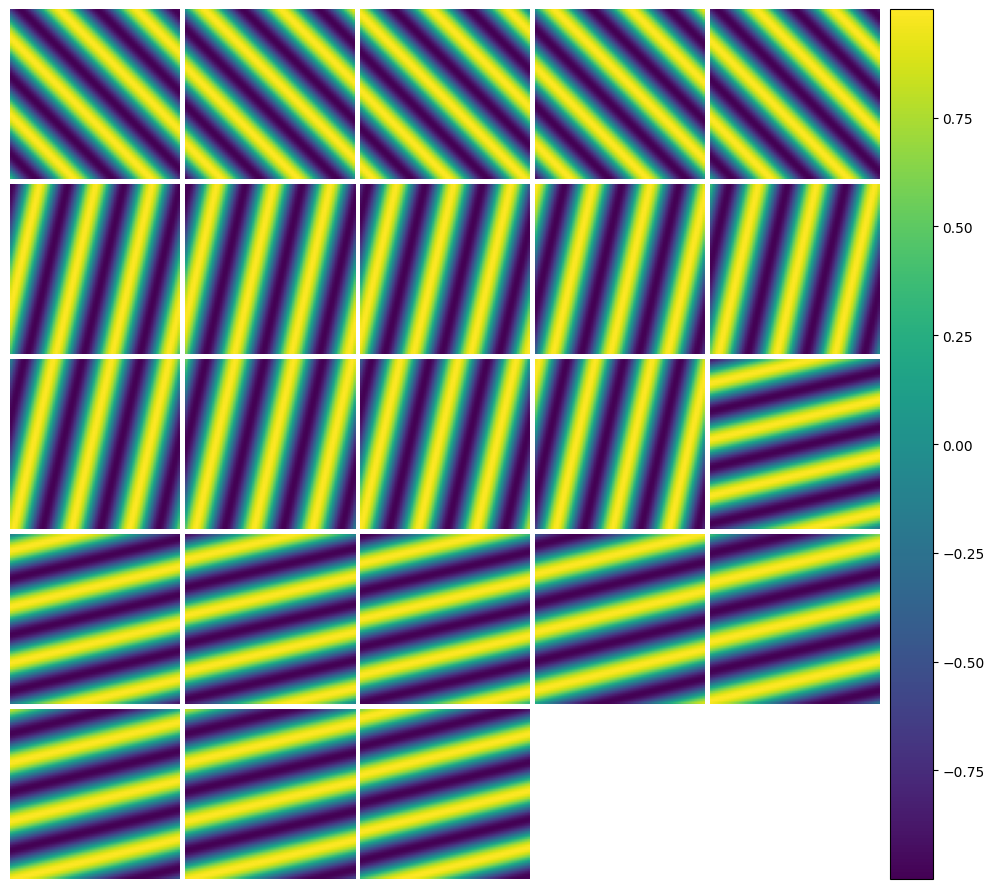

In [142]:
multiimshow(optimized_maps[sort_idxs], cmap="viridis", figsize=(10, 10));

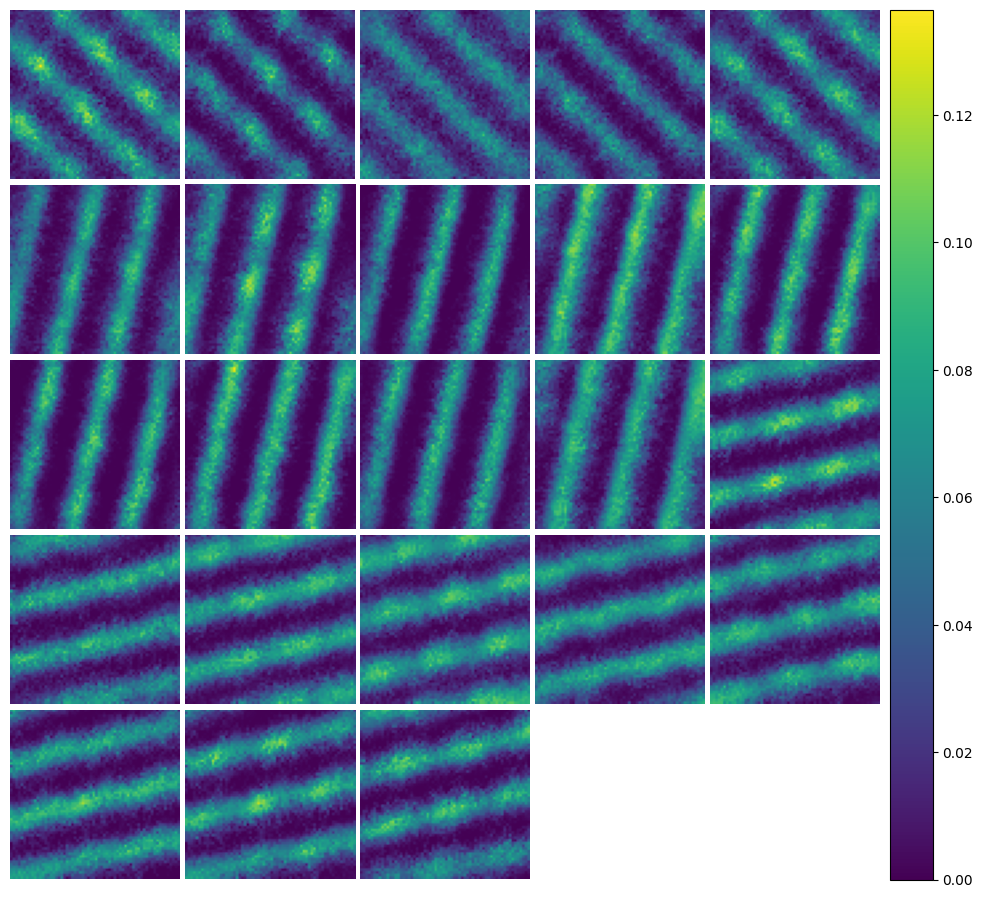

In [143]:
multiimshow(subselectmaps[sort_idxs], cmap="viridis", figsize=(10, 10));

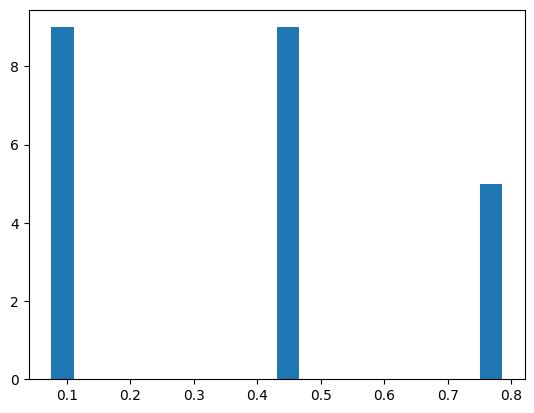

In [144]:
plt.hist(optimas[:,1]%np.pi/3, bins=20);

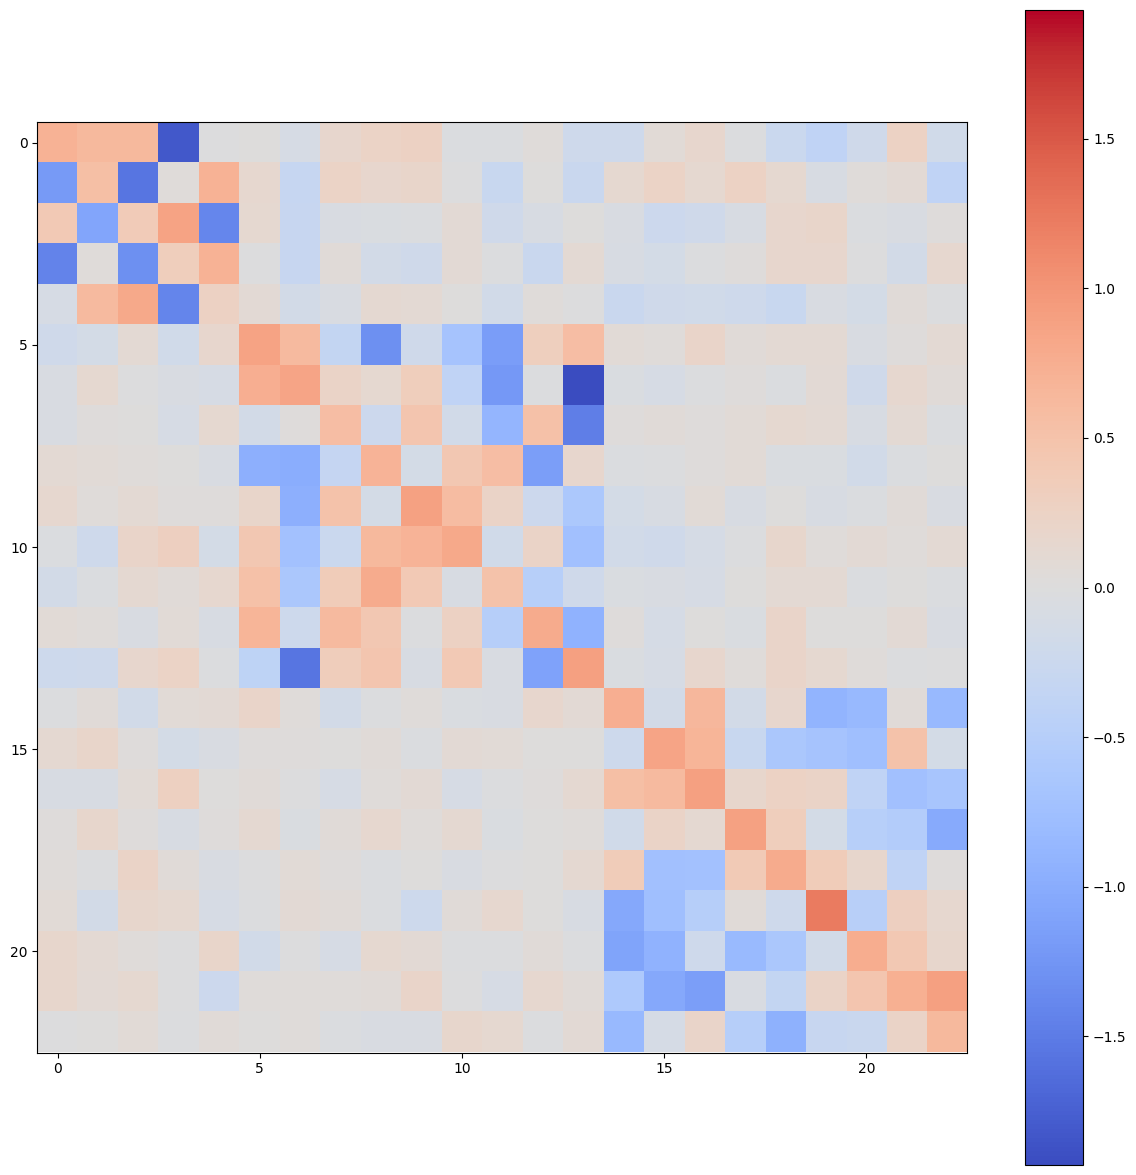

In [145]:
gg = model.gg.weight.detach().numpy()[grid_score < threshold]
gg = gg.T[grid_score < threshold].T
gg = gg[sort_idxs].T[sort_idxs].T
#gg = gg[sort_phases].T[sort_phases].T
#gg = gg[sort_orientations].T[sort_orientations].T
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(gg, cmap="coolwarm", vmin=-np.max(np.abs(gg)), vmax=np.max(np.abs(gg)))
plt.colorbar()

In [146]:
phases

array([[30, 35],
       [23, 41],
       [27, 31],
       [32, 35],
       [42, 39],
       [37, 31],
       [22, 25],
       [29, 34],
       [36, 30],
       [32, 37],
       [37, 38],
       [32, 44],
       [25, 37],
       [31, 28],
       [22, 28],
       [39, 25],
       [27, 35],
       [34, 30],
       [26, 35],
       [35, 34],
       [30, 22],
       [26, 32],
       [25, 36],
       [32, 31],
       [25, 42],
       [33, 36],
       [22, 33],
       [38, 24],
       [26, 36],
       [38, 22],
       [42, 23],
       [33, 28],
       [37, 36],
       [39, 34],
       [23, 35],
       [29, 35],
       [42, 25],
       [42, 39],
       [30, 23],
       [43, 32],
       [28, 22],
       [23, 31],
       [36, 41],
       [28, 29],
       [30, 25],
       [38, 32],
       [35, 33],
       [40, 29],
       [27, 19],
       [36, 31],
       [32, 20],
       [24, 33],
       [34, 39],
       [35, 39],
       [30, 26],
       [27, 28],
       [24, 26],
       [39, 40],
       [40, 29

In [147]:
phases0[sort_phases0]

array([-2.3336853 , -1.59222932,  0.39130372,  1.55114268,  2.56102044])

In [148]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(subselectmaps[sort_idxs][:5].reshape(-1,res**2).T)

PCA(n_components=2)

In [149]:
pca.components_, pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)

(array([[ 0.61709152, -0.38992143, -0.09970711, -0.39322518,  0.55008343],
        [ 0.19339139,  0.50035724, -0.64172669,  0.43554849,  0.33275633]]),
 array([0.65477818, 0.3074676 ]),
 0.9622457848237078)

In [73]:
pca.components_, pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)

(array([[ 0.56403378, -0.02819183, -0.40910634, -0.38731868,  0.60306497],
        [ 0.32259767, -0.67343788,  0.45130336,  0.42297113,  0.24460757]]),
 array([0.64277817, 0.29481983]),
 0.9375980003519022)

In [150]:
low_dim = pca.transform(subselectmaps[sort_idxs][:5].reshape(-1,res**2).T)

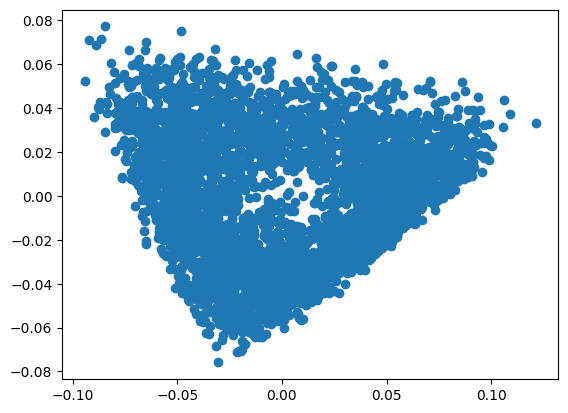

In [151]:
plt.scatter(*low_dim.T)

In [152]:
subselectmaps[sort_idxs][:5].reshape(-1,res**2).shape

(5, 4096)

In [153]:
subselectmaps[sort_idxs][:5].shape

(5, 64, 64)

In [154]:
from sklearn import p
subselectmaps[sort_idxs][:5]

ImportError: cannot import name 'p' from 'sklearn' (/Users/vemundss/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/__init__.py)